In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score
import warnings

Будемо розглядати модель SpectralClustering на двох датасетах другої розмірності.
Вона використовує граф найближчих сусідів (KNN), після чого задає відповідність міток за допомогою алгоритму k-середніх.
Таким чином, метод k-середніх за допомогою цього **ядерного перетворення** здатний виявити більш складні нелінійні межі між кластерами.
Роботу алгоритму можна розбити на 3 кроки:

1.   параметр ***affinity***
Будується граф подібності на основі матриці подібності ( її можна передати як параметр, або після fit вивести як атрибут affinity_matrix_).
Можна використовувати як метод KNN, так і гаусівське ядро (rbf kernel)
2.  знаходяться **власні числа** і вектори матриці Лапласіану, що будується на основі матриці подібності або її аналогу-матриці суміжності. Стратегія налаштовується в параметрі ***eigen_solver***
3. встановлення міток
  На вибір два методи в параметрі ***assign_labels***: kmeans або discretize.

В роботі використано 3 метрики (в алгоритмі їх обчислення використовується ентропія та умовна ймовірність), причому в ході будуть пояснюватися результати.


1. Однорідність (Homogeneity) – максимальна, якщо кластер
складається лише з об'єктів одного класу;
2. Повнота (Completeness) – максимальна, якщо всі об'єкти з
класу належать лише до певного кластеру;
3. V-measure – середнє гармонічне метрик Homogeneity та
Completeness.




In [ ]:
# ступінь відображення масивів
import sys
# np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=1000)

In [ ]:
np.random.seed(0)
n_points_per_cluster = 300
C1 = [-6, -2] + 0.7*np.random.randn(n_points_per_cluster, 2)
C2 = [-2, 2] + 0.3*np.random.randn(n_points_per_cluster, 2)
C3 = [1, -2] + 0.2*np.random.randn(n_points_per_cluster, 2)
C4 = [4, -4] + 0.1*np.random.randn(n_points_per_cluster, 2)
C5 = [5 , 0] + 1.4*np.random.randn(n_points_per_cluster, 2)
C6 = [5, 6] + 2.0*np.random.randn(n_points_per_cluster, 2)
X = np.vstack((C1, C2, C3, C4, C5, C6))

# штучний масив міток для 6 класів
y = np.full((1800), 1, dtype=int)
for i,j in zip(range(300, 1800, 300),range(2,7)):
  y[i:i+300]=j
y

array([1, 1, 1, ..., 6, 6, 6])

In [ ]:
# масштабування+центрування масиву
scaler = StandardScaler()
X = scaler.fit_transform(X)
# plt.scatter(X[:,0], X[:,1], marker="*")

number of samples:1800



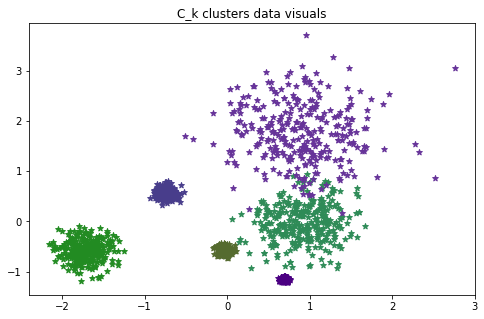

In [ ]:
print(f"number of samples:{X.shape[0]}\n")
plt.figure(figsize=(8,5))

plt.title("C_k clusters data visuals")
for i, j in zip([C1, C2, C3, C4, C5, C6], ['forestgreen','darkslateblue','darkolivegreen','indigo','seagreen','rebeccapurple']):
  plt.scatter(scaler.transform(i)[:,0], scaler.transform(i)[:,1], marker="*", c=j)
plt.show()

Функції візуалізації та обчислення метрик:

In [ ]:
def plot_clusters(array, model, colors='viridis'):
  plt.figure(figsize=(7,4.5))
  plt.scatter(array[:,0], array[:,1], c=model.labels_, marker="*", cmap = colors)
  plt.show()

def metrics(labels_true, labels):
  print("Homogeneity: %0.3f" % homogeneity_score(labels_true, labels))
  print("Completeness: %0.3f" % completeness_score(labels_true, labels))
  print("V-measure: %0.3f" % v_measure_score(labels_true, labels))

def fit_knn(X, model):
  with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            model.fit(X)

Модель з гаусівським ядром та методом присвоєння міток 'discretize'
Homogeneity: 0.941
Completeness: 0.942
V-measure: 0.942


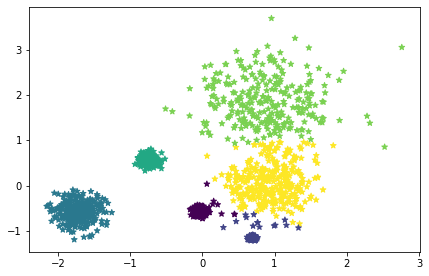

In [ ]:
# параметр gamma обрала емпірично
clustering = SpectralClustering(n_clusters=6,
        eigen_solver="arpack",
        affinity="rbf",
        assign_labels="discretize", gamma=10).fit(X)

print("Модель з гаусівським ядром та методом присвоєння міток 'discretize'")
metrics(y, clustering.labels_)
plot_clusters(X, clustering)

Модель, що використовує граф найближчих сусідів та методом присвоєння міток k-середніх
Homogeneity: 0.968
Completeness: 0.968
V-measure: 0.968


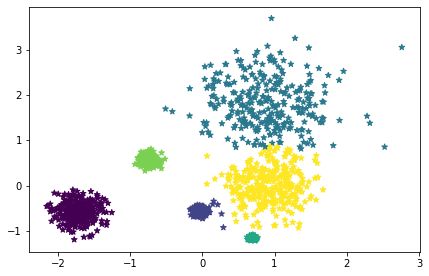

In [ ]:
clustering1 = SpectralClustering(n_clusters=6,
        eigen_solver="arpack",
        affinity="nearest_neighbors")
fit_knn(X, clustering1)

# print(clustering1.affinity_matrix_)
# print(clustering.labels_.size)
print("Модель, що використовує граф найближчих сусідів та методом присвоєння міток k-середніх")
metrics(y, clustering1.labels_)
plot_clusters(X, clustering1)


Отже, друга модель дає гарний результат. Спробуємо ще кілька альтернативних моделей спектральної кластеризації з використанням lobpcg (локально оптимальний градієнт для стратегії eigenvalue decomposition)

In [ ]:
alt_model1 = SpectralClustering(n_clusters=6,
        eigen_solver="lobpcg",
        affinity="nearest_neighbors")

alt_model2 = SpectralClustering(n_clusters=6,
        eigen_solver="lobpcg",
        affinity="nearest_neighbors", assign_labels="discretize")

fit_knn(X, alt_model1)
print("Модель, використовує граф найближчих сусідів та метод присвоєння міток k-середніх")
metrics(y, alt_model1.labels_)

fit_knn(X, alt_model2)
print("Модель, використовує граф найближчих сусідів та метод присвоєння міток discretize")
metrics(y, alt_model2.labels_)

Модель, використовує граф найближчих сусідів та метод присвоєння міток k-середніх
Homogeneity: 0.813
Completeness: 0.817
V-measure: 0.815
Модель, використовує граф найближчих сусідів та метод присвоєння міток discretize
Homogeneity: 0.969
Completeness: 0.969
V-measure: 0.969


Досліджуємо модель на різних значеннях параметру-кількості кластерів

Splitting into 2 clusters


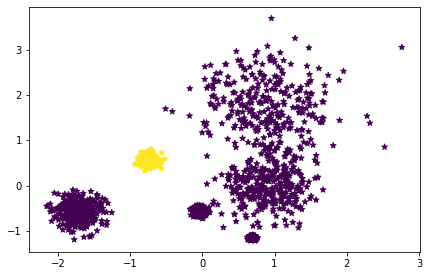

Homogeneity: 0.251
Completeness: 1.000
V-measure: 0.402
Splitting into 3 clusters


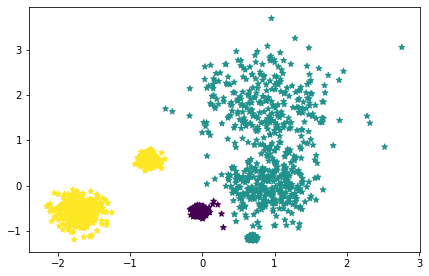

Homogeneity: 0.558
Completeness: 0.986
V-measure: 0.713
Splitting into 4 clusters


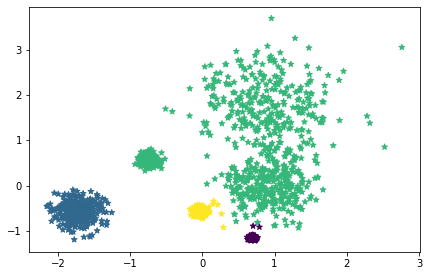

Homogeneity: 0.684
Completeness: 0.983
V-measure: 0.807
Splitting into 5 clusters


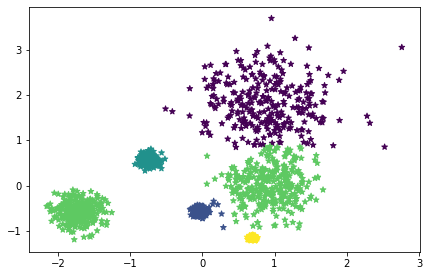

Homogeneity: 0.834
Completeness: 0.960
V-measure: 0.893


In [ ]:
for i in range (2,6):
  clustering_nk = SpectralClustering(n_clusters=i,
          eigen_solver="arpack",
          affinity="nearest_neighbors")
  fit_knn(X, clustering_nk)

  print(f"Splitting into {i} clusters")
  plot_clusters(X, clustering_nk)
  metrics(y, clustering_nk.labels_)

Досліджуємо модель на підвибірках даних. Бачимо, що метрики дають нижчий результат, оскільки деякі кластери так само гарно відділяються, а ті, що з шумом, мають вже відносно більшу вагу

number of samples:180



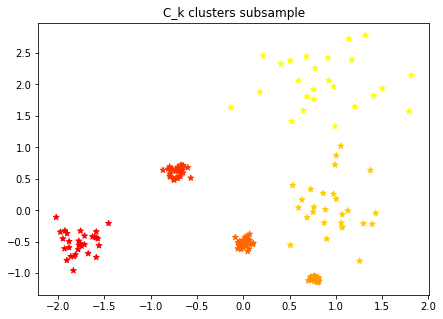


Результат кластеризації:


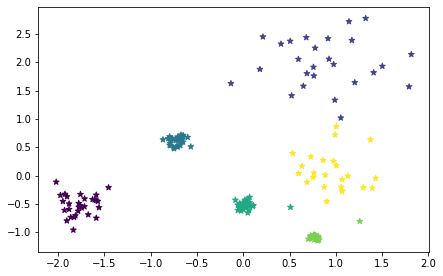

Homogeneity: 0.958
Completeness: 0.960
V-measure: 0.959


In [ ]:
sub_x, _, sub_y, _ = train_test_split(X, y, train_size=0.1, random_state=42)

# стандартизуємо підвибірку та візуалізуємо дані
sub_x = StandardScaler().fit_transform(sub_x)
print(f"number of samples:{sub_x.shape[0]}\n")

plt.figure(figsize=(7,5))
plt.title("C_k clusters subsample")
plt.scatter(sub_x[:, 0], sub_x[:, 1], c=sub_y, marker="*", cmap='autumn')
plt.show()

# будуємо модель та візуалізуємо кластери
clustering_subs = SpectralClustering(n_clusters=6,
        eigen_solver="arpack",
        affinity="nearest_neighbors")
fit_knn(sub_x, clustering_subs)

print("\nРезультат кластеризації:")
plot_clusters(sub_x, clustering_subs)
metrics(sub_y, clustering_subs.labels_)

Датасет make_blobs

In [ ]:
X_, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
rng = np.random.RandomState(13)
X_stretched = np.dot(X_, rng.randn(2, 2))

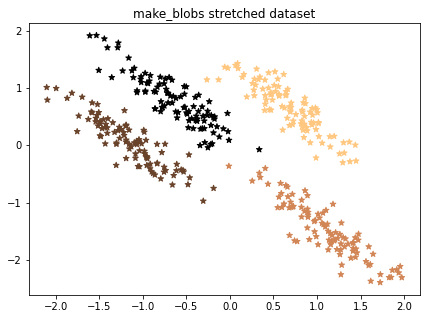

In [ ]:
# стандартизуємо датасет та візуалізуємо кластери
X_stretched  = StandardScaler().fit_transform(X_stretched)

plt.figure(figsize=(7,5))
plt.title("make_blobs stretched dataset")
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=y_true, marker="*", cmap='copper')
plt.show()

Модель, використовує граф найближчих сусідів та метод присвоєння міток k-середніх
Homogeneity: 0.970
Completeness: 0.970
V-measure: 0.970


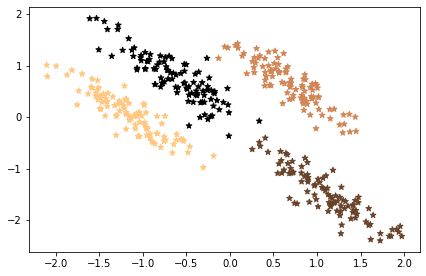

In [ ]:
clustering2 = SpectralClustering(n_clusters=4,
        eigen_solver="arpack",
        affinity="nearest_neighbors").fit(X_stretched)

# print(clustering2.labels_)
# print(y_true)

print("Модель, що використовує граф найближчих сусідів та метод присвоєння міток k-середніх")
metrics(y_true, clustering2.labels_)
plot_clusters(X_stretched, clustering2, colors='copper')

Альтернативні моделі:

Модель з гаусівським ядром та методом присвоєння міток 'discretize'
Homogeneity: 0.980
Completeness: 0.980
V-measure: 0.980


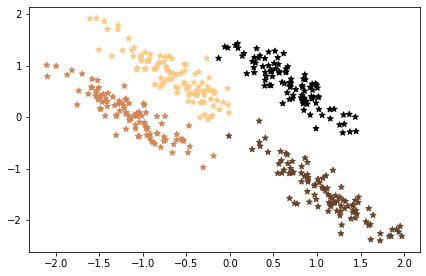

Модель, що використовує граф найближчих сусіді та метод присвоєння міток 'discretize'
Homogeneity: 0.980
Completeness: 0.980
V-measure: 0.980


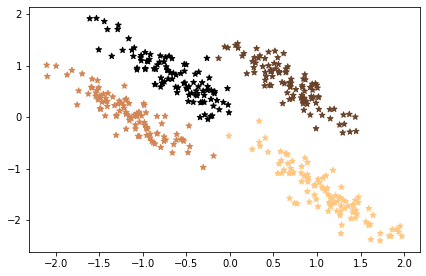

In [ ]:
alt_m1= SpectralClustering(n_clusters=4,
        eigen_solver="arpack",
        affinity="rbf",
        assign_labels="discretize", gamma=20).fit(X_stretched)
alt_m2 = SpectralClustering(n_clusters=4,
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        assign_labels="discretize").fit(X_stretched)

print("Модель з гаусівським ядром та методом присвоєння міток 'discretize'")
metrics(y_true, alt_m1.labels_)
plot_clusters(X_stretched, alt_m1, colors='copper')

print("Модель, що використовує граф найближчих сусіді та метод присвоєння міток 'discretize'")
metrics(y_true, alt_m2.labels_)
plot_clusters(X_stretched, alt_m2, colors='copper')

Досліджуємо модель на різних значеннях параметру-кількості кластерів. Бачимо, що метрика completeness дає високий результат, бо всі об'єкти з певного класу належатимуть до певного кластеру

Splitting into 2 clusters


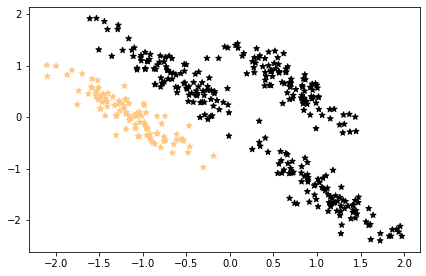

Homogeneity: 0.406
Completeness: 1.000
V-measure: 0.577
Splitting into 3 clusters


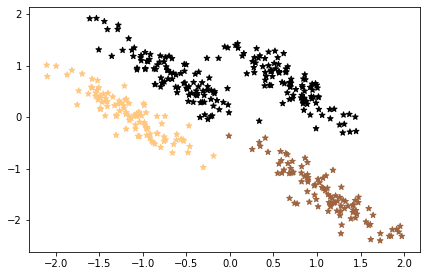

Homogeneity: 0.750
Completeness: 1.000
V-measure: 0.857
Splitting into 5 clusters


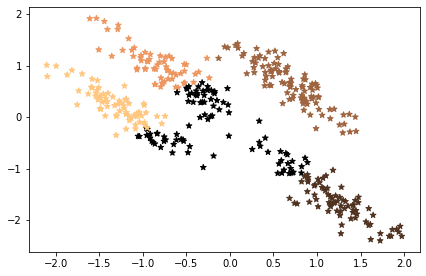

Homogeneity: 0.812
Completeness: 0.705
V-measure: 0.755
Splitting into 6 clusters


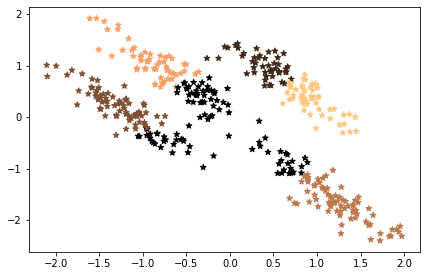

Homogeneity: 0.813
Completeness: 0.640
V-measure: 0.717


In [ ]:
for i in [2,3,5,6]:
  clustering_nk = SpectralClustering(n_clusters=i,
          eigen_solver="arpack",
          affinity="nearest_neighbors", assign_labels="discretize").fit(X_stretched)

  print(f"Splitting into {i} clusters")
  plot_clusters(X_stretched, clustering_nk, colors='copper')
  metrics(y_true, clustering_nk.labels_)

Досліджуємо модель на підвибірках даних. Результат залежить від того, чи попадають у вибірку точки, що створюють "шум" 

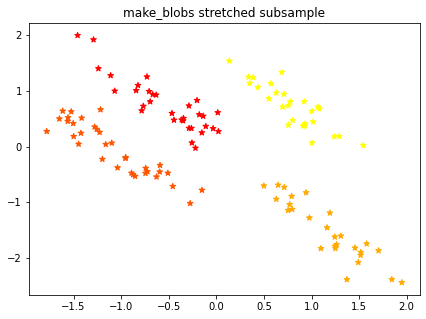

Результат кластеризації:


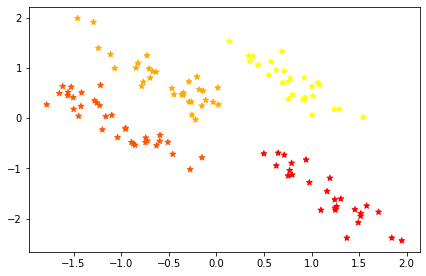

Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000


In [ ]:
x, _, y, _ = train_test_split(X_stretched, y_true, train_size=0.3, random_state=42)

# стандартизуємо підвибірку та візуалізуємо кластери
x = StandardScaler().fit_transform(x)

plt.figure(figsize=(7,5))
plt.title("make_blobs stretched subsample")
plt.scatter(x[:, 0], x[:, 1], c=y, marker="*", cmap='autumn')
plt.show()

cluster_subsample = SpectralClustering(n_clusters=4,
        eigen_solver="arpack",
        affinity="nearest_neighbors").fit(x)

print("Результат кластеризації:")
plot_clusters(x, cluster_subsample, colors='autumn')
metrics(y, cluster_subsample.labels_)